In [1]:
import GetOldTweets3 as got
import lxml
import pyquery
import requests
import os
import sys
import time
import pandas as pd
import spacy
from datetime import datetime as dt
from dateutil.parser import parse
import calendar

from newsplease.config import CrawlerConfig
from newsplease.config import JsonConfig
from newsplease.helper import Helper
from newspaper import Article

import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
from cycler import cycler
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
project_dir = str(os.path.dirname((os.path.abspath(''))))
sys.path.append(project_dir)
print(project_dir)
figures_folder = project_dir + '/Images/'
base_path = project_dir + '/data/'
print(base_path)

/Users/samypalaniappan/Desktop/Metis_Working_Directory/Projects/Project-4-Stock Superclusters/notebooks
/Users/samypalaniappan/Desktop/Metis_Working_Directory/Projects/Project-4-Stock Superclusters/notebooks/data/


In [3]:
def import_files(path_name, name):
    file = path_name+name
    df = pd.read_csv(file, delimiter=',')
    return df

In [4]:
def clean_table(df, cols):
    df = df[cols]
    df = df.dropna()
    df = df.drop_duplicates().reset_index()
    df = df.drop(columns='index')
    for i in range(len(df)-1):
        df.loc[i,'retrieved_on'] = dt.utcfromtimestamp(float(df.loc[i,'retrieved_on']))
        df.loc[i,'date'] = dt.strptime(str(df.loc[i,'retrieved_on']), '%Y-%m-%d %H:%M:%S')
    df = df.drop(columns='retrieved_on')
    result_df = df.sort_values(['date'])
    return result_df

In [5]:
def add_senti(df):
    senti = []
    for row in range(len(df)-1):
        senti.append(sia.polarity_scores(df.loc[row,'selftext']))
    senti_df = pd.DataFrame(senti)
    result_df = pd.concat([df, senti_df], join='outer', axis=1)
    return result_df

In [6]:
stocks = import_files(path_name=base_path, name='/raw_scraped/stocks.csv')
cols = ['author', 'selftext', 'retrieved_on', 'score']
stocks_df = clean_table(stocks, cols)
stocks_senti_df = add_senti(stocks_df)
stocks_senti_df.head()

FileNotFoundError: [Errno 2] File b'/Users/samypalaniappan/Desktop/Metis_Working_Directory/Projects/Project-4-Stock Superclusters/notebooks/data//raw_scraped/stocks.csv' does not exist: b'/Users/samypalaniappan/Desktop/Metis_Working_Directory/Projects/Project-4-Stock Superclusters/notebooks/data//raw_scraped/stocks.csv'

In [25]:
crypto = import_files(path_name=base_path, name='/scraped/crypto.csv')
cols = ['author', 'selftext', 'retrieved_on', 'score']
crypto_df = clean_table(crypto, cols)
crypto_senti_df = add_senti(crypto_df)
crypto_senti_df.head()

,author,selftext,score,date,neg,neu,pos,compound
0,arsonbunny,With so much uncertainty right now it would be...,12974,2018-01-18 15:50:20,0.066,0.809,0.125,0.9996
1,normal_rc,Starbucks Chairman Howard Shultz said the coff...,5807,2018-01-28 01:28:41,0.028,0.907,0.065,0.6926
2,arsonbunny,"Well its happened, the crypto market just expe...",4913,2018-02-04 06:57:29,0.073,0.813,0.114,0.9993
3,UhNotzee,Today I went to my local RBC (Royal Bank of Ca...,2907,2018-05-11 21:12:05,0.111,0.702,0.187,0.9882
4,bLbGoldeN,It has been just under three years since I've ...,2797,2019-06-27 12:58:19,0.089,0.798,0.113,0.9453


In [26]:
gold = import_files(path_name=base_path, name='/scraped/gold.csv')
cols = ['author', 'selftext', 'retrieved_on', 'score']
gold_df = clean_table(gold, cols)
gold_senti_df = add_senti(gold_df)
gold_senti_df.head()

,author,selftext,score,date,neg,neu,pos,compound
0,bjtbtc,"Hello Gold members,\n\nAs a young and inexperi...",2,2018-01-18 09:08:17,0.0,0.857,0.143,0.9541
1,bullishbars,"According to the Wall Street Journal, precious...",1,NaT,NaN,NaN,NaN,NaN


In [28]:
bit = import_files(path_name=base_path, name='/scraped/bitcoin.csv')
cols = ['author', 'selftext', 'retrieved_on', 'score']
bit_df = clean_table(bit, cols)
bit_senti_df = add_senti(bit_df)
bit_senti_df.head()

,author,selftext,score,date,neg,neu,pos,compound
0,PineappleFund,Hello! \n\nI remember starting at bitcoin a fe...,15363,2017-12-14 02:30:30,0.026,0.724,0.250,0.9967
1,EaFaer,"On November 28, 2017, the US Senate, Committee...",12358,2017-12-09 03:58:45,0.058,0.852,0.090,0.9813
2,OurLordAndSaviorSam,He talked the class through the entire concept...,588,2018-01-19 15:02:20,0.062,0.797,0.141,0.9314
3,coinmoon_com,Disruption.,286,2018-07-08 21:57:50,1.000,0.000,0.000,-0.3612
4,TWO-WHEELER-MAFIA,The reserve bank of India put this restriction...,199,2019-09-26 09:37:52,0.091,0.865,0.044,-0.7932


In [29]:
def date_filter(df_list, start_date, end_date):
    start = dt.strptime(start_date, '%Y-%m-%d')
    end = dt.strptime(end_date, '%Y-%m-%d')
    for i in range(0, len(df_list)):
        mask = (df_list[i]['date'] > start) & (df_list[i]['date'] <= end)
        df_list[i] = df_list[i][mask]
        df_list[i] = df_list[i].sort_values('date')
    return df_list

In [30]:
def plot_senti(df_list, legend):
    default_cycler = (cycler(color=['r', 'b', 'g', 'orange']) + cycler(marker=['o', '+', '*', 'v']))
    plt.rc('lines', linewidth=4)
    plt.rc('axes', prop_cycle=default_cycler)
    plt.figure(figsize=(12,6))
    for i in range(0, len(legend)):
        x=df_list[i].loc[:,'date']
        y=df_list[i].loc[:,'compound'] 
        plt.plot(x, y, label=legend[i])
    plt.legend(fontsize='16')
    plt.ylabel('Sentiment', fontsize='16')
    plt.xlabel('Date', fontsize='16')
    plt.title('Sentiment Analysis for Reddit Financial Data')
    plt.show()

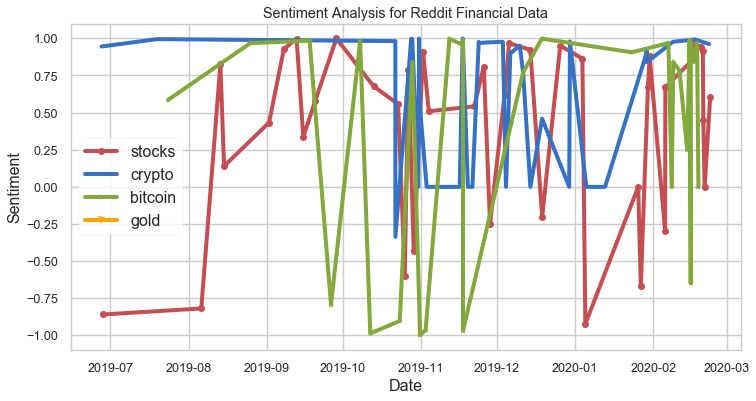

In [31]:
scraped_list = [stocks_senti_df, crypto_senti_df, bit_senti_df, gold_senti_df]
start_date='2019-1-1'
end_date='2020-02-24'
df_list = date_filter(scraped_list, start_date, end_date)
df_list

legend_list = ['stocks', 'crypto', 'bitcoin', 'gold']
plot_senti(df_list, legend_list)

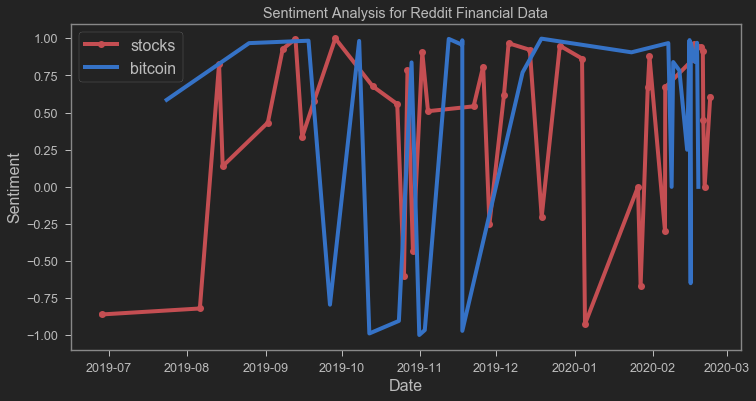

In [126]:
scraped_list = [stocks_senti_df, bit_senti_df]
start_date='2019-1-1'
end_date='2020-02-24'
df_list = date_filter(scraped_list, start_date, end_date)
df_list

legend_list = ['stocks', 'bitcoin']
plot_senti(df_list, legend_list)

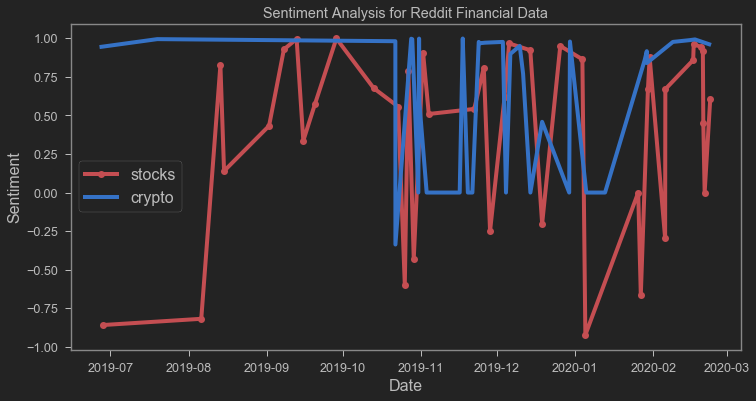

In [127]:
scraped_list = [stocks_senti_df, crypto_senti_df]
start_date='2019-1-1'
end_date='2020-02-24'
df_list = date_filter(scraped_list, start_date, end_date)
df_list

legend_list = ['stocks', 'crypto']
plot_senti(df_list, legend_list)